# 3. Simulation: Imbalanced Friedman1
Description: 
* Using friedman1-dataset from sklearn.datasets: imbalanced by cutting of 'y' > 17 with 70% of the data
* Taking samples from the dataset with preserving the proportions of the classes in both splits (training, test and validation) by stratification and comparing it to random splitting
* visual inspection of distribution of train-test split
* fit RandomForestRegressor
* RandomizedSearchCV for hyperparameter tuning
* Stratification based on quantiles with pd.qcut

In [27]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
from utils_Nadja import generate_friedman1, to_dataframe, plot_data_3D, train_test_stratified, evaluate_rf, fold_visualizer

## Dataset

In [29]:
features, y = generate_friedman1(n_samples=1000)
(features, y)

(array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
        ...,
        [0.1531445 , 0.72811644, 0.60025141, 0.73125059, 0.76974662],
        [0.97541037, 0.57356328, 0.34164111, 0.64846456, 0.06844071],
        [0.89739732, 0.11938101, 0.32784284, 0.81574538, 0.59731238]]),
 array([16.83826156, 12.51782504,  5.86968919,  7.53187897,  9.45737165,
        10.88906915, 21.29818121, 19.26769898, 16.61008184, 12.44163815,
        22.83735821,  6.46236702, 10.38662987,  9.88601081, 21.21547558,
        17.60207288, 12.69134012, 18.39401421, 13.47560394,  8.14785175,
        10.94077686,  7.1379749 , 16.40332854, 21.67042684, 10.53641573,
        14.12700131, 13.85231999, 14.34693947, 11.33172011,  2.61396215,
        18.66039324, 12.27788144, 12.83883023, 12.78596049,  5.84676689,
        14.00663761, 14.88326076, 16.4903815 , 13.8271

In [30]:
generated_data =to_dataframe(features=features, y=y)
generated_data

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.838262
1,0.155995,0.058084,0.866176,0.601115,0.708073,12.517825
2,0.020584,0.969910,0.832443,0.212339,0.181825,5.869689
3,0.183405,0.304242,0.524756,0.431945,0.291229,7.531879
4,0.611853,0.139494,0.292145,0.366362,0.456070,9.457372
...,...,...,...,...,...,...
995,0.446726,0.123450,0.205980,0.000943,0.039265,3.658595
996,0.977284,0.242354,0.663311,0.839100,0.550660,18.450667
997,0.153145,0.728116,0.600251,0.731251,0.769747,14.794133
998,0.975410,0.573563,0.341641,0.648465,0.068441,17.154440


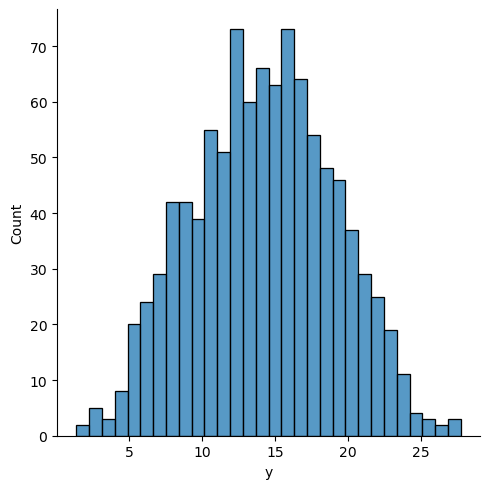

In [31]:
sns.displot(generated_data, x='y', bins = 30)

proportion of original data set 0.71
number of observaions 709


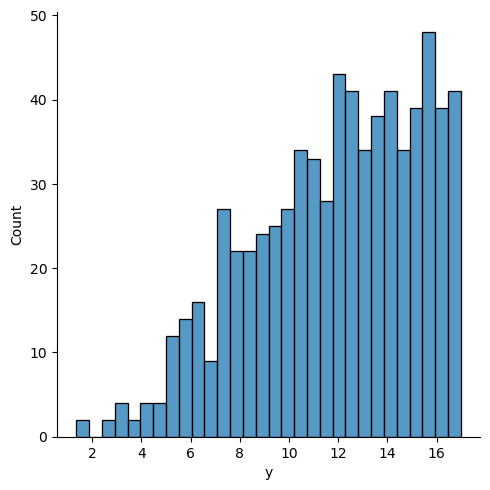

In [32]:
# make y distirbution imbalanced by deleting rows where ['y'] > 17 -> also makes data set smaller
df=generated_data.drop(generated_data[generated_data['y'] > 17].index)
#drop index
df=df.reset_index(drop=True)
sns.displot(df, x='y', bins = 30)

# proportion 
print("proportion of original data set", round(df.shape[0]/generated_data.shape[0], 2))
print("number of observaions", df.shape[0])

In [33]:
#plot_data_3D(df, ['X3', 'X4','X5'])

## Random Forest without stratificaation

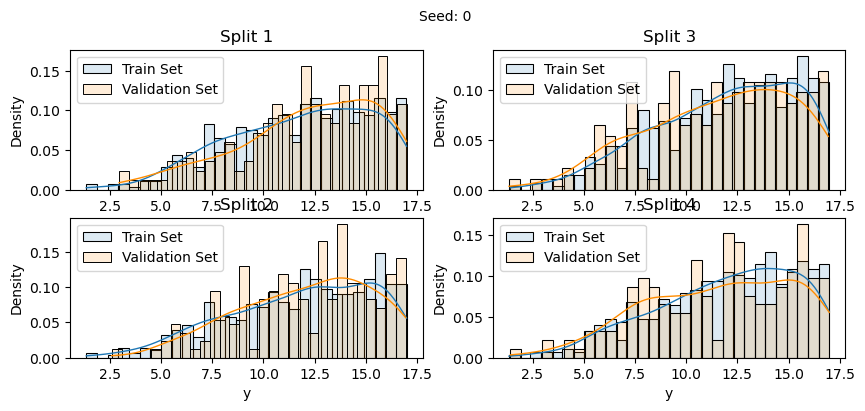

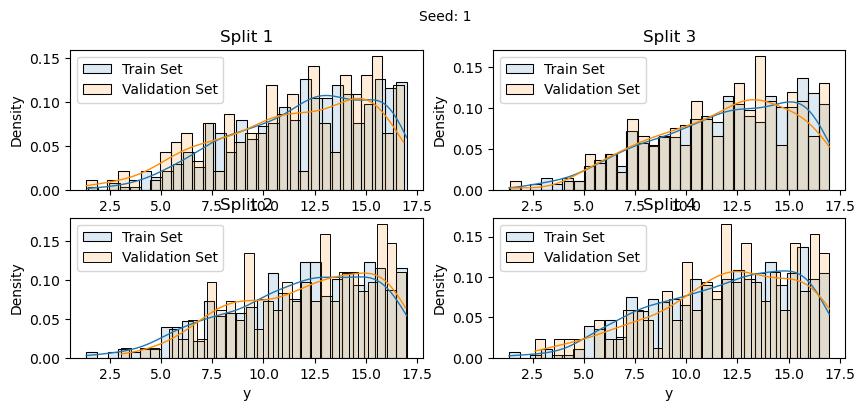

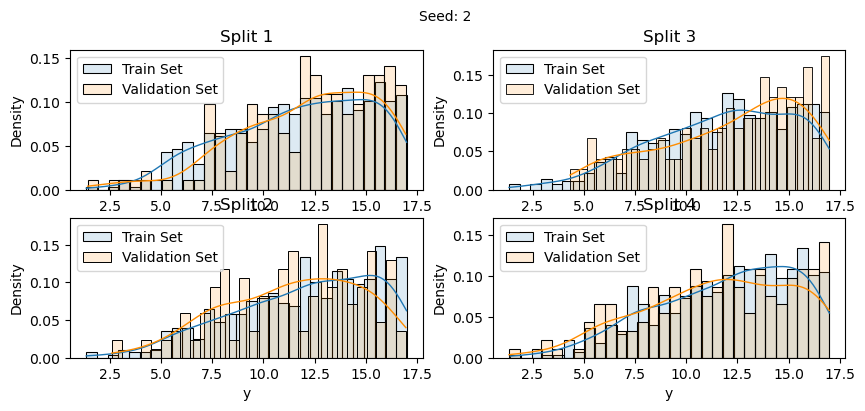

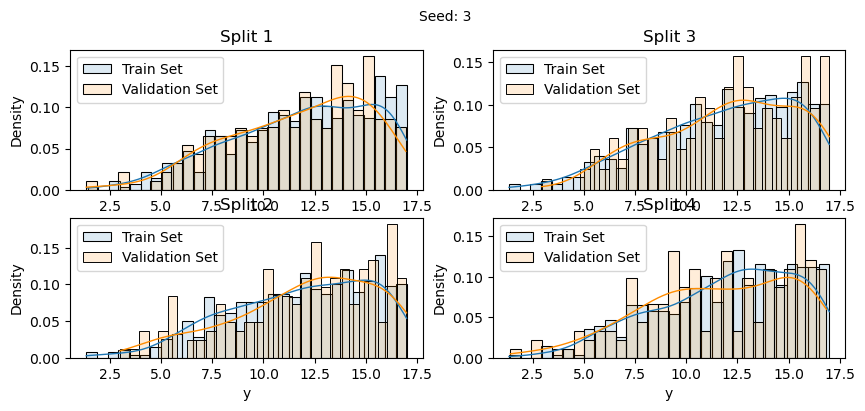

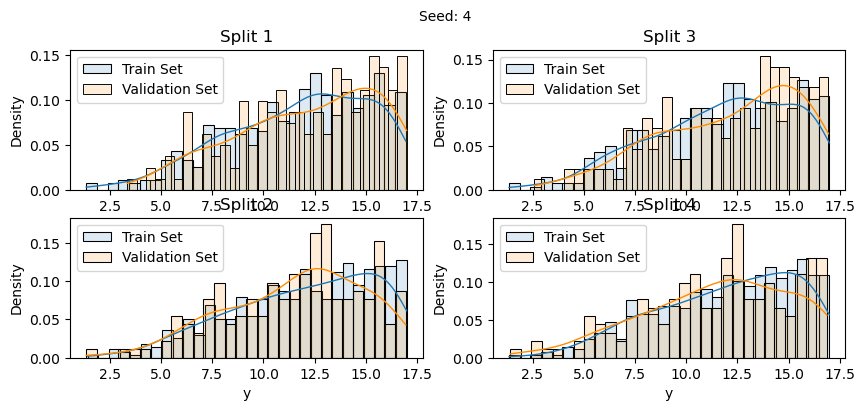

In [34]:
from sklearn.model_selection import KFold
labels = df['y']


for i in range(5):
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)

In [35]:
# first devide data in train/test data (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[: , :-1], df['y'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(567, 5) (142, 5) (567,) (142,)


In [36]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}

# Initialize Random Forest model
rf_model=RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_rf,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

In [37]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)

# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}

Best Cross-Validated Mean Squared Error: -3.2415


In [38]:
# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
train_score=best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print(f"Train Set R^2 Score (random split): {train_score:.4f} \nTest Set R^2 Score(random split): {test_score:.4f}")

Train Set R^2 Score (random split): 0.8576 
Test Set R^2 Score(random split): 0.7312


## Random Forest with stratifications

In [39]:
from sklearn.model_selection import StratifiedKFold

In [40]:
def create_cont_folds(df, n_s=4, n_grp=10, seed=1):
    # StratifiedKFold for classification
    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    # q/n_grp = Number of quantiles
    grp = pd.qcut(x = df, q = n_grp, labels=False)
    target = grp
    
    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no
    
    cv_splits = []

    for i in range(num_of_folds):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(labels))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))
        
    return cv_splits

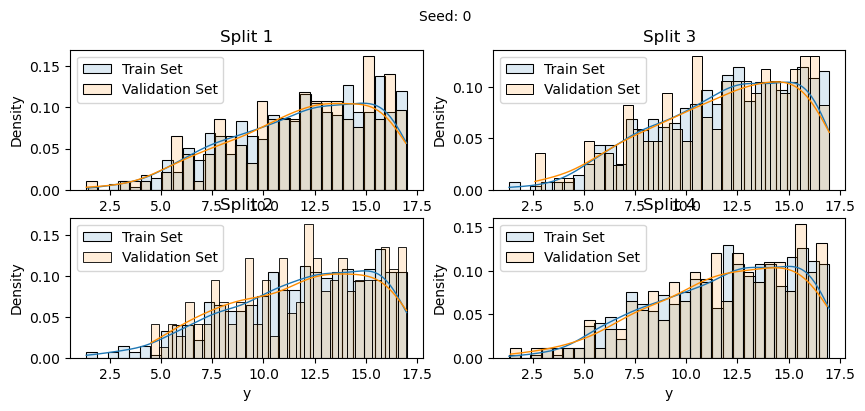

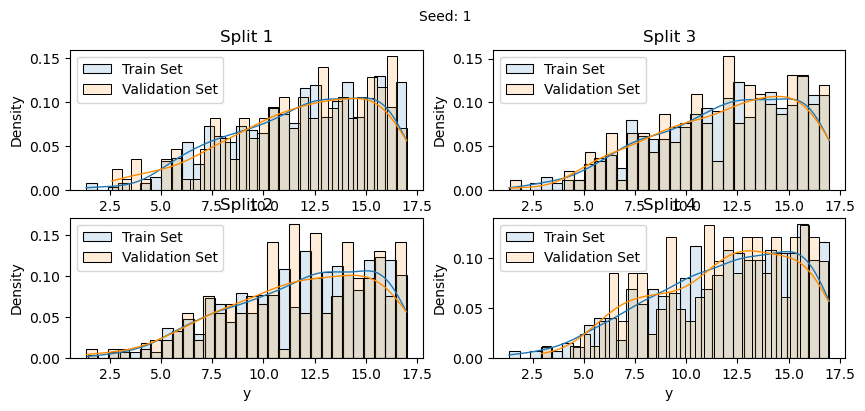

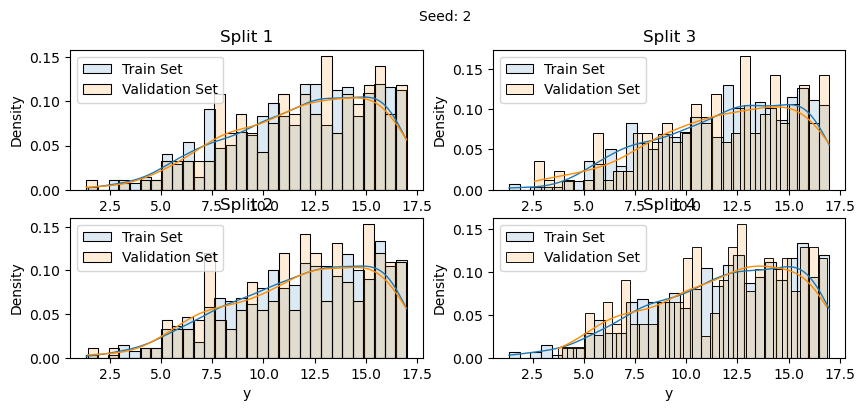

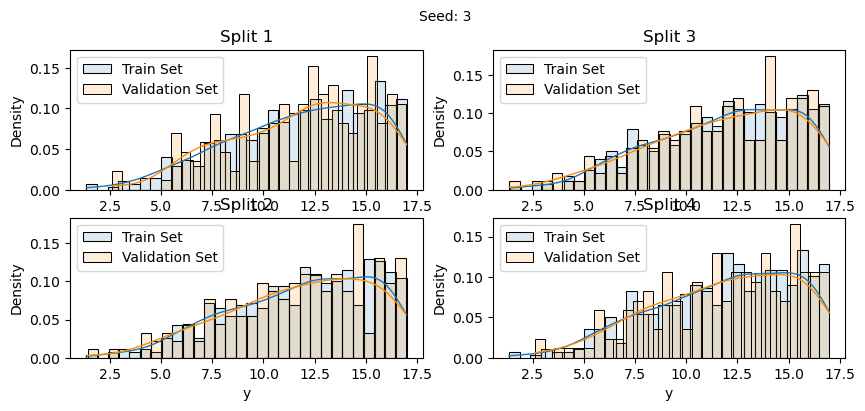

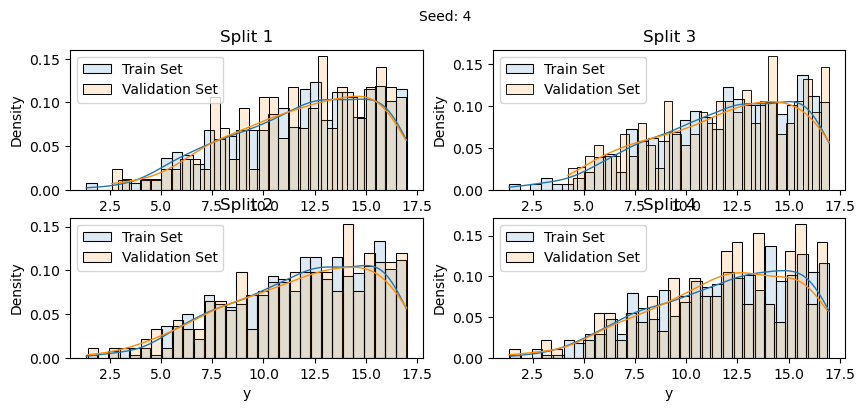

In [41]:
num_of_folds = 4
num_of_groups = 10

for i in range(5):
    cv_splits = create_cont_folds(labels, n_s=num_of_folds, n_grp=num_of_groups, seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [42]:
#@Nadja: create funcsion for train-test-split
X_train_stratified = df.loc[cv_splits[0][0], df.columns != 'y']
y_train_stratified = df.loc[cv_splits[0][0], 'y']

X_test_stratified = df.loc[cv_splits[0][1], df.columns != 'y']
y_test_stratified = df.loc[cv_splits[0][1], 'y']

# Verify the sizes of the train and test sets
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Train set size: (567, 5) (567,)
Test set size: (142, 5) (142,)


In [43]:
X_train_stratified

,X1,X2,X3,X4,X5
0,0.374540,0.950714,0.731994,0.598658,0.156019
2,0.020584,0.969910,0.832443,0.212339,0.181825
3,0.183405,0.304242,0.524756,0.431945,0.291229
4,0.611853,0.139494,0.292145,0.366362,0.456070
5,0.785176,0.199674,0.514234,0.592415,0.046450
...,...,...,...,...,...
701,0.423770,0.342133,0.961551,0.444852,0.489048
703,0.395053,0.051263,0.401876,0.673756,0.450350
705,0.545696,0.204064,0.291911,0.748609,0.482601
706,0.446726,0.123450,0.205980,0.000943,0.039265


In [44]:
labels = y_train_stratified ### @Nadja: problem labels within function not defined

#cv splits
cv_splits_training = create_cont_folds(labels, n_s=num_of_folds, n_grp=num_of_groups, seed=i)

# Initialize Random Forest model
rf_model_stratified=RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_stratified = RandomizedSearchCV(estimator=rf_model_stratified, param_distributions=param_rf,
                                   n_iter=10, cv = cv_splits_training, scoring='neg_mean_squared_error', random_state=42)

In [45]:
# Perform the random search on the training set
random_search_stratified.fit(X_train_stratified, y_train_stratified) ### @Nadja attention: need to change as first cv_split is used for test set

# Display the best parameters found by random search
print("Best Parameters:", random_search_stratified.best_params_)

# Display the cross-validated score with the best parameters
best_score = random_search_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}

Best Cross-Validated Mean Squared Error: -3.2111


In [46]:
# Evaluate the model with the best parameters on the test set
best_model_stratified = random_search_stratified.best_estimator_
train_score_stratiefied =best_model_stratified.score(X_train_stratified, y_train_stratified)
test_score_stratified = best_model_stratified.score(X_test_stratified, y_test_stratified)
print(f"Train Set R^2 Score stratified: {train_score_stratiefied:.4f} \nTest Set R^2 Score stratified: {test_score_stratified:.4f}")

Train Set R^2 Score stratified: 0.8533 
Test Set R^2 Score stratified: 0.6987


In [47]:
print(f"Train Set R^2 Score (random split): {train_score:.4f} \nTest Set R^2 Score: {test_score:.4f}")

Train Set R^2 Score (random split): 0.8576 
Test Set R^2 Score: 0.7312


## Comparison stratified vs. random sample

In [48]:
evaluate_rf(random_search_stratified, X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified)

Train Set R^2 Score: 0.8533 
Test Set R^2 Score: 0.6987 
 Train Set MSE Score: 1.7316 
Test Set MSE Score: 3.4261


{'train r2': 0.8533201357605023,
 'test r2': 0.6986867810917019,
 'train mse': 1.7315789015572434,
 'test mse': 3.426143695672741}

In [49]:
evaluate_rf(random_search, X_train, X_test, y_train, y_test)

Train Set R^2 Score: 0.8576 
Test Set R^2 Score: 0.7312 
 Train Set MSE Score: 1.6841 
Test Set MSE Score: 2.9918


{'train r2': 0.8576255403158949,
 'test r2': 0.7311508198539353,
 'train mse': 1.6841043481211955,
 'test mse': 2.9917947299458523}